In [1]:
import cv2
import pickle
import os
os.environ['GLOB_v'] = '0'
os.environ["GLOG_minloglevel"] = "3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import gc
import glob
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
#from torch.cuda import empty_cache
import concurrent.futures
from collections import deque
from IPython.display import display, Image, clear_output

size = 20

E0000 00:00:1742453550.969721   96492 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742453550.974482   96492 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742453550.986500   96492 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742453550.986514   96492 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742453550.986515   96492 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742453550.986516   96492 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
def get_video_path_list(dir_path):
    dir_list = glob.glob(dir_path)

    video_list = []

    for list in dir_list:
        file_list = []

        file_list.append(str(list).split('/')[-1])
        file_list.append(glob.glob(list + "/*"))
        video_list.append(file_list)

    return video_list

def extract_pose_landmarks(results):
    xyz_list = []

    points = [
        11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28
    ]

    neck_x = (results.pose_landmarks.landmark[11].x + results.pose_landmarks.landmark[12].x) / 2
    neck_y = (results.pose_landmarks.landmark[11].y + results.pose_landmarks.landmark[12].y) / 2
    #neck_z = (results.pose_landmarks.landmark[11].z + results.pose_landmarks.landmark[12].z) / 2

    for idx, lm in enumerate(results.pose_landmarks.landmark):
        #if idx in points:
        x = lm.x - neck_x
        y = lm.y - neck_y
        #z = lm.z - neck_z

        xyz_list.append(x)
        xyz_list.append(y)
        #xyz_list.append(z)

    return xyz_list

def generate_dataset(path):
    cap = cv2.VideoCapture(path)
    mp_pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

    xyz_list_list = []
    if cap.isOpened():
        while True:
            ret, frame = cap.read()
            if ret:
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (640, 480))
                results = mp_pose.process(image)

                if results.pose_landmarks is None: continue

                xyz_list = extract_pose_landmarks(results)

                xyz_list_list.append(xyz_list)
            else:
                break

        cap.release()

    change_amounts = calculate_change_amounts(xyz_list_list)

    return change_amounts

def calculate_change_amounts(xyz_list_list):
    change_amounts_list = []

    for i in range(1, len(xyz_list_list)):
        previous_xyz = np.array(xyz_list_list[i - 1])
        current_xyz = np.array(xyz_list_list[i])

        # 변화량 계산 (현재 프레임 - 이전 프레임)
        change_amounts = current_xyz - previous_xyz
        change_amounts_list.append(change_amounts)  # 변화량 추가

    return change_amounts_list

def differences_landmark(xyz_list):
  
    diff_list = []
    # 연속 프레임 간의 차분 계산
    for i in range(1, len(xyz_list)):
        frame_diff = []
        prev = xyz_list[i - 1]
        curr = xyz_list[i]
        # 각 관절별로 2개씩 묶어서 차분 계산
        for j in range(0, len(prev), 2):
            dx = curr[j] - prev[j]
            dy = curr[j + 1] - prev[j + 1]
            frame_diff.append(dx)
            frame_diff.append(dy)
        diff_list.append(frame_diff)
    
    return diff_list

In [2]:
video_list = get_video_path_list("ㅊ/*")
dataset = []

for classes in video_list:
    class_label = classes[0]
    if class_label == 'standing':
        label = 0
    elif class_label == 'pushup':
        label = 1
    elif class_label == 'stand_knee_raise':
        label = 2
    elif class_label == 'stand_shoulder_press':
        label = 3
    
    cnt = 0
    for file in classes[1]:
        cnt += 1
        pose_data = generate_dataset(file)

        # pose_data = differences_landmark(pose_data)

        if cnt % 20 == 0:
            gc.collect()
            #empty_cache()

        for idx in range(0, len(pose_data), size):
            seq_list = pose_data[idx:idx+size]
            if len(seq_list) == size:
                dataset.append({'key':label,'value':seq_list})

        clear_output()

NameError: name 'get_video_path_list' is not defined

In [18]:
import cv2
import mediapipe as mp
import numpy as np
import os

mp_pose = mp.solutions.pose

def extract_pose_landmarks(image, pose):
    results = pose.process(image)
    if not results.pose_landmarks:
        return None
    landmarks = []
    for lm in results.pose_landmarks.landmark:
        landmarks.extend([lm.x, lm.y, lm.z])
    return landmarks

def process_videos_from_folders(base_folder, sequence_length=20):
    data = []
    labels = []
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
    label_map = {'pushup': 0, 'stand_shoulder_press': 1}
    
    for label_name, label in label_map.items():
        folder_path = os.path.join(base_folder, label_name)
        for video_name in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_name)
            cap = cv2.VideoCapture(video_path)
            sequence = []
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                landmarks = extract_pose_landmarks(frame_rgb, pose)
                if landmarks:
                    sequence.append(landmarks)
                    if len(sequence) == sequence_length:
                        data.append(sequence)
                        labels.append(label)
                        sequence.pop(0)  # 시퀀스에서 첫 번째 프레임 제거
            cap.release()
    pose.close()
    return np.array(data), np.array(labels)

# 데이터셋 폴더 경로
dataset_path = '/home/shin/deeplearning-repo-1/dataset'

# 모든 영상 처리
X, y = process_videos_from_folders(dataset_path)

I0000 00:00:1742454036.347847   96492 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742454036.349674   97742 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742454036.416349   97730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742454036.454866   97729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [6]:
with open('keypoints.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [37]:
with open('keypoints.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
X, y = [], []

for data in dataset:
    y.append(data['key'])
    X.append(data['value'])

X = np.array(X)
y = np.reshape(y, (len(y), 1))

In [23]:
X.shape, y.shape

((5590, 19, 99), (5590,))

In [6]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [24]:
# y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4472, 19, 99), (1118, 19, 99), (4472,), (1118,))

In [25]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation="relu"))
model.add(Dense(2, activation="softmax"))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='Adam', loss='mse')
model.summary()

/home/shin/venv/project/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 19, 64)         │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,154 (301.38 KB)

 Trainable params: 77,154 (301.38 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/100


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 2)

In [23]:
model.save("faa.keras")

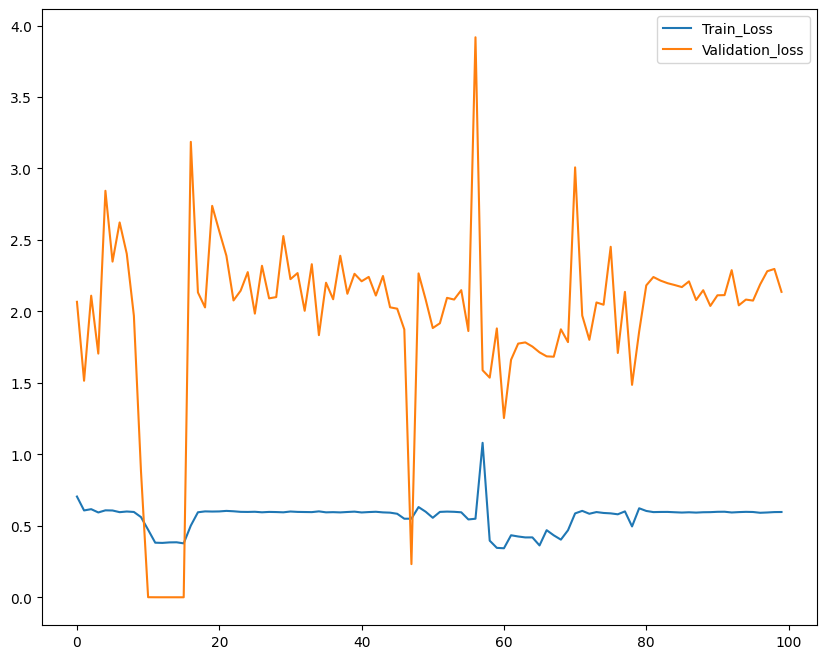

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(hist.history['loss'], label='Train_Loss')
plt.plot(hist.history['val_loss'], label='Validation_loss')
plt.legend()
plt.show()

In [13]:
def video_show(frame, width=400):
    _, buffer = cv2.imencode(".jpg", frame)
    clear_output(wait=True)
    display(Image(data=buffer, width=width))

In [6]:
model = load_model('faa.keras')

In [16]:
path = "/home/shin/deeplearning-repo-1/dataset/stand_knee_raise/kneeUp_4.mp4"
mp_pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
# Webcam 시작
cap = cv2.VideoCapture(path)
sequence = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Mediapipe로 pose 처리를 수행
    results = mp_pose.process(image)

    if results.pose_landmarks is not None:
        # 랜드마크 좌표 추출 및 변화량 계산
        xyz_list = extract_pose_landmarks(results)

        # 변화량 계산
        if len(sequence) > 0:
            # Calculate change amount from the last frame to the current frame
            previous_xyz = sequence[-1]
            current_xyz = xyz_list

            # 변화량 추가
            change_amount = np.array(current_xyz) - np.array(previous_xyz)
            sequence.append(change_amount)  # 변화량을 sequence에 추가
        else:
            # 첫 프레임의 경우 변화량 없음
            sequence.append(xyz_list)

        # 20 프레임 수집 후 예측
        if len(sequence) == 20:
            data = np.array(sequence).reshape(1, 20, 24)  # 20 프레임, 12 랜드마크 (x, y)
            predict = model.predict(data)  # 모델 예측
            predict_class = np.argmax(predict, axis=1)  # 클래스 예측

            # 예측 결과 출력
            print(f"Predicted Class: {predict_class}")

            # 예측 후 시퀀스 초기화 (원하는 경우)
            sequence = []

    # 영상 보이기
    cv2.imshow('Pose Estimation', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # 'q' 키를 눌러 종료
        break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1742452066.497370   76495 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742452066.499990   91144 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742452066.587227   91132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742452066.627438   91136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Class: [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Class: [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Class: [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Class: [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Class: [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Class: [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Class: [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Class: [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Class: [1]


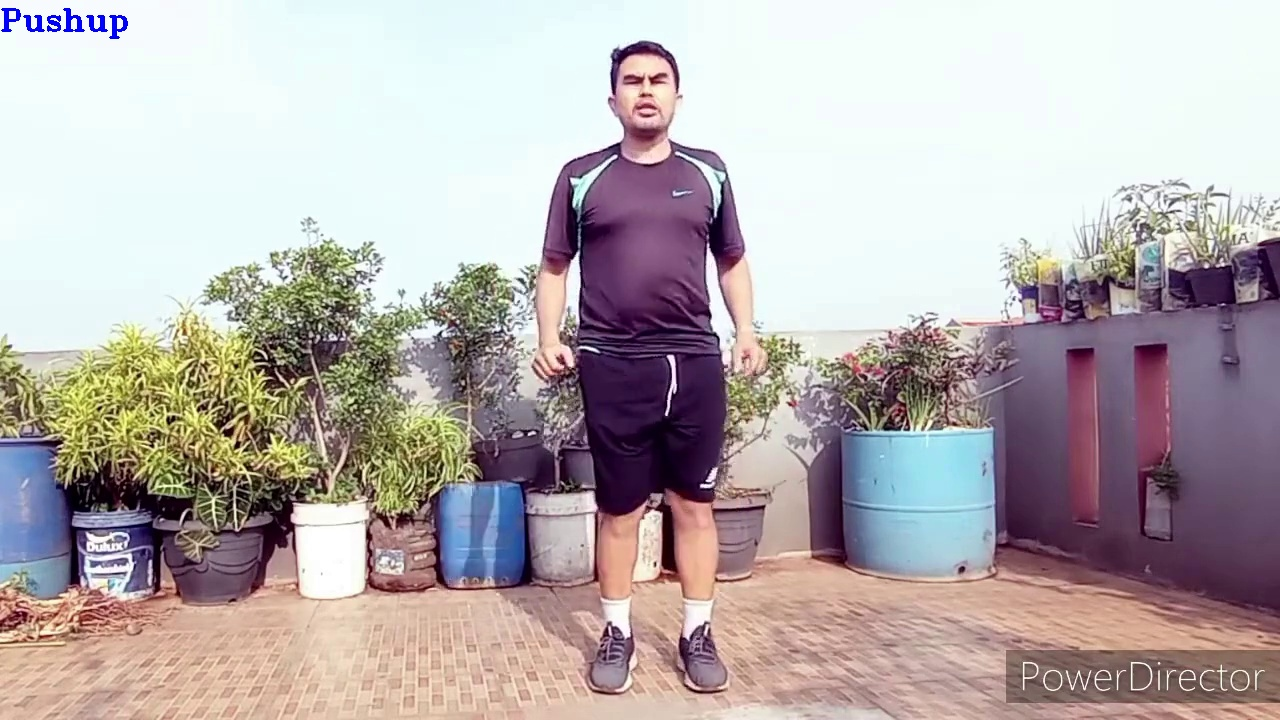

In [15]:
path = "/home/shin/deeplearning-repo-1/dataset/stand_knee_raise/kneeUp_4.mp4"
cap = cv2.VideoCapture(path)

mp_pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
sequence = deque(maxlen=20)
if cap.isOpened():
    while True:
        ret, frame = cap.read()
        if ret:
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (640, 480))

            results = mp_pose.process(image)

            if results.pose_landmarks is None: continue
            
            sequence.append(extract_pose_landmarks(results))

            if len(sequence) == 20:
                data = np.array(sequence).reshape(1, 20, 24)

                predict = model.predict(data)
                predict_class = np.argmax(predict, axis=1)

                if predict_class == 0:
                    label = "Standing"
                elif predict_class == 1:
                    label = "Pushup"
                elif predict_class == 2:
                    label = "Staning Knee Raise"
                elif predict_class == 3:
                    label = "Shoulder Press"

                cv2.putText(frame, label, (0, 30), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 0, 0), 2)

                #sequence = sequence[1:]
            elif len(sequence) > 20:
                sequence.pop(0)

            video_show(frame, 640)
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

In [23]:
gc.collect()

1668